# Phase 1: Data Acquisition, Data Preparation & Exploratory Data Analysis

## 1. Environment Set Up and Data Acquisition:

To get set up we will follow the following steps:

1. Load the packages we need for phase 1
2. Scrape the column names:
    1. make a request to the names file
    2. regex to capture column names
    3. remove extra information that was grabbed in scrape
    4. insert `poisonous` in first position (it was excluded as it is not an attribute )
3.  Acquire data and combine with 2. 

In [1]:
#1 package loading:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import re


# get columns names froms names file
#location of names
http = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names'
#request to names file
req = requests.request('get',url = http)
#search to match columns
search = re.compile('[0-9]{1,2}. ([-?\w]+):')
#finding based on search dropping some extra data
names = search.findall(req.text)[3:]
#inserting poisonous which was not listed in attribute list
names.insert(0,'poisonous')

#created data frame with data plus names derived above
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',names = names)

#sanity check
df.head()

,poisonous,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## 2. Data Prep Feature Engineering:

As we read about in [Week13 readings](https://elitedatascience.com/feature-engineering)  and in class there are several processes that we should embark on before doing any predictions on a data set. These include:

- Subsetting - the features we plan on utilizing in our model are the only ones we will process to simplify everything below
- Handling missing data - most modeling algorithms require data that is free from gaps (no nulls)
- Combining sparse classes - categorical classes that have very few records can lead to overfit models 
- Adding dummy variables - for each categorical value we will create a boolean indicator value

###  Subsetting:

Now that we have all the data we are ready to do some prep. First we will create the subset with the following features:

1. `Poisonous` - our outcome of interest
2. `Odor` (required as part of assignment)
3. `Spore-print-color` (selected because I know how useful this is in mushroom identification)
4. `Bruises?` (as I know some mushrooms with volatile chemicals in them react to air I am curious if this can be utlized to predict poisonousness)

In [2]:
# selecting collumns
columns = ['poisonous','odor','bruises?', 'spore-print-color']
#creating subset
df_for_pred = df.loc[:,columns]
#sanity check
df_for_pred.head()

,poisonous,odor,bruises?,spore-print-color
0,p,p,t,k
1,e,a,t,n
2,e,l,t,n
3,p,p,t,k
4,e,n,f,n


### Checking For Null Values

In [3]:
df_for_pred.isnull().sum()

poisonous            0
odor                 0
bruises?             0
spore-print-color    0
dtype: int64

Conclusion: The dataset is free from nulls.



### Combining Sparse Classes 
#### Initial Visualizing:

To aid in identifying sparse classes and learning more about our data we will create visualizations of each of our data points. As they are all categorical, these will be bar charts. 

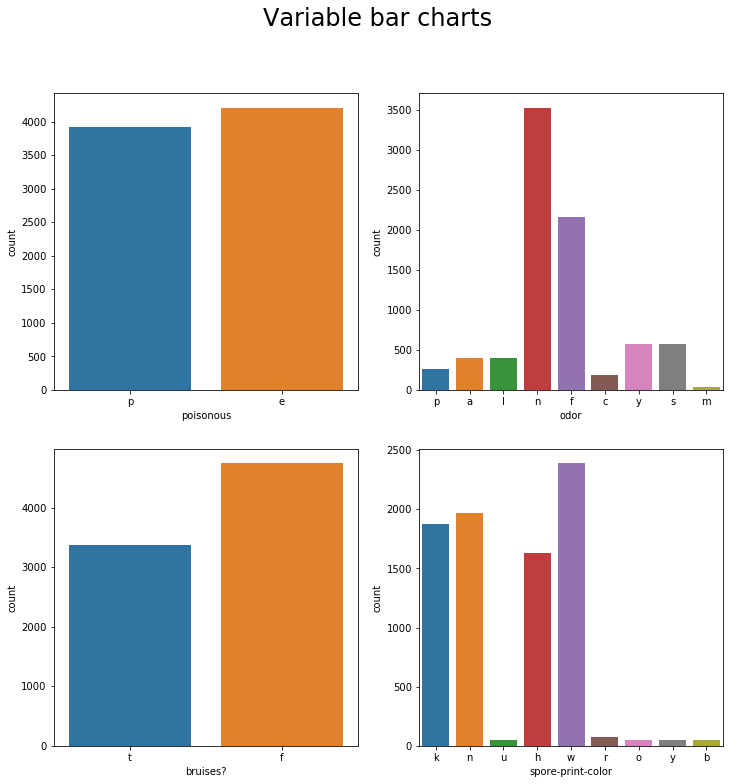

In [4]:
# barchart of subset variables
plt.figure(figsize=(12,12));
plt.suptitle('Variable bar charts',fontsize=24)
plt.tight_layout();
plt.subplot(2,2,1);
sns.countplot(x='poisonous', data = df_for_pred);
plt.subplot(2,2,2);
sns.countplot(x='odor', data=df_for_pred);
plt.subplot(2,2,3);
sns.countplot(x='bruises?', data=df_for_pred);
plt.subplot(2,2,4);
sns.countplot(x='spore-print-color',data=df_for_pred);

**Conclusions:** 

**Sparse Classes:**  
The `spore-print-color` variable appears to have several sparse classes that we should investigate combining. Odor could also be considered but will be excluded as it is included at the driection of the assignment's documentation and there is no mention of this process in the directions provided.

**Other:**   
Other conclusions that can be taken out of this initial look at our data:
`Poisonous` - our observations appear to be approximately evenly distributed. 
  
#### Counting
We will next look at the value counts and decide what classes from `spore-print-color` to combine

In [5]:
display(df_for_pred['spore-print-color'].value_counts())

w    2388
n    1968
k    1872
h    1632
r      72
u      48
b      48
o      48
y      48
Name: spore-print-color, dtype: int64

#### Combining spares classes

The classes `r, u, b, o , y` will all be combined into a variable `other`. They all have a fraction of the number of observations of the other values.

In [6]:
#setting sparse to other with isin method 
df_for_pred.loc[df_for_pred['spore-print-color'].isin(['r','u','b','o','y']),'spore-print-color'] = 'other'

#sanity check 
display(df_for_pred['spore-print-color'].value_counts())

w        2388
n        1968
k        1872
h        1632
other     264
Name: spore-print-color, dtype: int64

### Adding dummy variables: 

All of our variables will require some modification to make them ready for predictive modeling.

- `Poisonous`: as it has only 2 values we will make an in-line update and set P = to 1 and E = to 0 

- `Bruises?`: has two values T/F we will make t = 1 and f = 0

- `spore-print-color` and `odor` have `14` values between them (after combining sparse classes) so we will utilize the `.get_dummies` pandas function to split them into indicator variables so that our **analytical base table (ABT)** will contain `16` columns.

#### 1. Poisonous & Bruises?

In [7]:
#setting Poisonous = p to 1
df_for_pred.poisonous = (df_for_pred.poisonous == 'p').astype(int)
#verification
df_for_pred.poisonous.value_counts()

0    4208
1    3916
Name: poisonous, dtype: int64

In [8]:
#setting bruises? = t to 1
df_for_pred['bruises?'] = (df_for_pred['bruises?'] =='t').astype(int)

#sanity check 
df_for_pred['bruises?'].value_counts()

0    4748
1    3376
Name: bruises?, dtype: int64

#### 2. `Spore-Print-color` & `Odor` Get_Dummies

In [9]:
#get dummies function
df_with_dummies = pd.get_dummies(df_for_pred)
#sanity check
df_with_dummies.head()

,poisonous,bruises?,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_other,spore-print-color_w
0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


## 3. EDA: Exploratory Data Analysis: 

We will now finish the exploratory analysis [started above](#Initial-visualizing%3A) by looking at the relationship between our indicator (`Poisonous`) and  our predictor values.
### 1. Bruises & Poisonous:

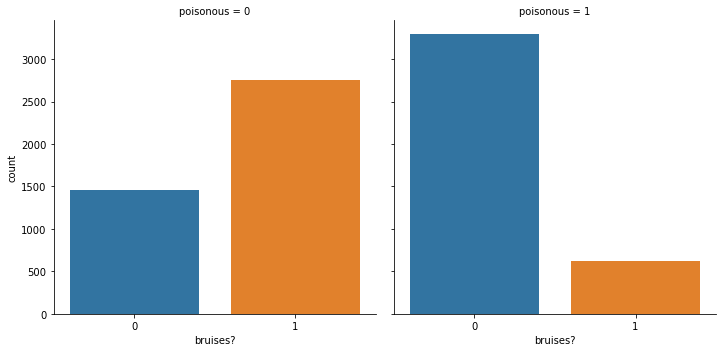

In [10]:
sns.catplot('bruises?',col ='poisonous',kind='count',data=df_for_pred);

**Conclusions:**

Mushrooms that bruise appear to be more likely to not be poisonous and mushrooms that don't bruise appear to be much more likely to be poisonous 

### 2. Spore Print Color:

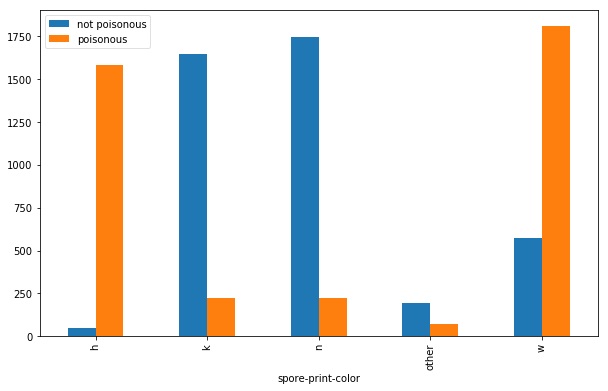

In [11]:
ax= pd.crosstab(df_for_pred['spore-print-color'],df_for_pred.poisonous).plot.bar(figsize=(10,6));           
ax.legend(['not poisonous','poisonous'],loc = 0,framealpha = .6);

**Conclusions:**

Spore print colors `h` and `w` appear to be significantly more likely to be poisonous, while `k`, `n` & `other` are much more likely to be not poisonous. 

### 3. Odor:

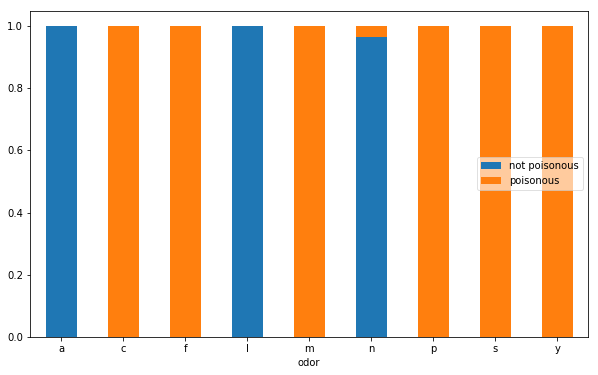

In [12]:
table = pd.crosstab(df_for_pred.odor,df_for_pred.poisonous)
ax = table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,figsize=(10,6))
plt.xticks(rotation=0);
ax.legend(['not poisonous','poisonous'],loc = 5,framealpha = .6);

**conclusions:**

While odor `n` is highly correlated to being not poisonous it is the worst predictor of the group the rest of the odor variables are perfect predictors of whether a mushroom is poisonous or not.

### EDA conclusions

While `Bruises?` and `sport print color` have some correlation to whether a mushroom is poisonous `odor`has a Very strong correlation and will be the strongest predictor of the bunch.

____

# Phase 2: Build Predictive Models

to build our models we will follow the following process:

1. Load packages

2. Set indicator variable to a variable `y` 

   ​	we will first set our predicator to an array called `y` 

3. We will now set our predictors

   1. Set all columns except `poisonous` from our ABT table  into `predictors`
   2. Use `predictors` to create an array containing our predictor values `X` 

4. Find our null error rate

   we will calculate the null error rate of the data ($sum poisonous/total number of observations$) so that we can compare our models performance against chance.

5. Initialize a model 
6. Fit the model
7. Predict 
8. Evaluate
9. repeat with other treatments (different columns) 

## Steps 1-3

In [13]:
# 1.load the LogisticRegression and metrics functions
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#2. set y varible with poisonous 
y  = df_with_dummies.poisonous.values
#3.A set a predictors varible starting with all varibles 
predictors = df_with_dummies.columns.values[1:]
#3.B set a x_train varible 
X = df_with_dummies[predictors].values

#sanity check x_train
print(X[:5])

[[1 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]]


In [14]:
#saniy check Y_train
y[:5]

array([1, 0, 0, 1, 0])

## Step 4. Null Error Rate:

In [15]:
null_error = df_with_dummies.poisonous.sum()/df_with_dummies.shape[0]
print(f'the null error rate of our initial data is:\n{null_error:.2} percent')

the null error rate of our initial data is:
0.48 percent


## Step 5 Initialize A Model: 

In [16]:
# initialize a Logistic 
model = LogisticRegression(solver = 'lbfgs') # set to remove warning and set to soon to be new default 

## Step 6 Fit Model:

In [17]:
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

## Step 7. Predict:

In [18]:
y_pred = model.predict(X)
y_pred[:5]

array([1, 0, 0, 1, 0])

## step 8 evaluate

In [19]:
model.score(X,y)

0.9852289512555391

In [20]:
for e,p in enumerate(predictors):
    print(f'{p} = {model.coef_[0][e]}')
    

bruises? = 0.9845965282309062
odor_a = -6.370764481090044
odor_c = 4.420225157911981
odor_f = 3.76038211006417
odor_l = -6.370764481090044
odor_m = 0.9214413785275798
odor_n = -5.538748545635588
odor_p = 3.86546193244749
odor_s = 2.655848383087907
odor_y = 2.65584838308791
spore-print-color_h = 0.83220191234103
spore-print-color_k = -2.2578961444188193
spore-print-color_n = -2.2760811411417
spore-print-color_other = 2.5765869553793483
spore-print-color_w = 1.124118255151537


In [21]:
print(metrics.classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4208
           1       1.00      0.97      0.98      3916

   micro avg       0.99      0.99      0.99      8124
   macro avg       0.99      0.98      0.99      8124
weighted avg       0.99      0.99      0.99      8124



**Conclusions:**
we have created a model that is 98.5% accurate. we will now see if we can do better
## steps 5-7 with different predictors
we will now evaluate whether we get a better results by dropping the Spore Color attribute and then looking at other combinations of variables


In [22]:
predictors = df_with_dummies.columns.values[1:11]
#3.B set a x_train varible
X = df_with_dummies[predictors].values 

In [23]:
X[:5]

array([[1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int32)

In [24]:
no_spores = LogisticRegression(solver = 'lbfgs') # set to remove warning and set to soon to be new default

no_spores.fit(X,y)

print(no_spores.score(X,y))
y_pred_no_spores = no_spores.predict(X)
print(metrics.classification_report(y,y_pred_no_spores))

0.9852289512555391
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4208
           1       1.00      0.97      0.98      3916

   micro avg       0.99      0.99      0.99      8124
   macro avg       0.99      0.98      0.99      8124
weighted avg       0.99      0.99      0.99      8124



In [25]:
for e,p in enumerate(predictors):
    print(f'{p} = {no_spores.coef_[0][e]}')

bruises? = -0.03089526539105707
odor_a = -6.05212780871172
odor_c = 2.4434515002141186
odor_f = 4.311672208387919
odor_l = -6.052127808711725
odor_m = 1.3432421558122447
odor_n = -5.19201809684145
odor_p = 2.6745932337323612
odor_s = 3.261143234879019
odor_y = 3.2611432348790164


**conclusions:** 
removing the spores attributes had NO effect in improving the model

## Steps 5-7 with Different Predictors
we will now evaluate whether we get a better result by dropping the `Bruises?` attribute

In [26]:
predictors = df_with_dummies.columns.values[2:11]
#3.B set a x_train varible 
X = df_with_dummies[predictors].values 

odor = LogisticRegression(solver = 'lbfgs') # set to remove warning and set to soon to be new default

odor.fit(X,y)

print(odor.score(X,y))
y_pred_odor = odor.predict(X)
print(metrics.classification_report(y,y_pred_odor))

0.9852289512555391
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4208
           1       1.00      0.97      0.98      3916

   micro avg       0.99      0.99      0.99      8124
   macro avg       0.99      0.98      0.99      8124
weighted avg       0.99      0.99      0.99      8124



In [27]:
for e,p in enumerate(predictors):
    print(f'{p} = {odor.coef_[0][e]}')

odor_a = -6.066793967856543
odor_c = 2.453403058081232
odor_f = 4.319592263029991
odor_l = -6.066793967856549
odor_m = 1.3510475136344242
odor_n = -5.195876581713545
odor_p = 2.6620081841786165
odor_s = 3.271683919464218
odor_y = 3.2716839194642247


**conclusions**
Dropping Bruises? does not increase the accuracy of the model

**next**
we will evaluate spore color on its own as a predictor

In [28]:
predictors = df_with_dummies.columns.values[12:]
#3.B set a x_train varible 
X = df_with_dummies[predictors].values 

spores = LogisticRegression(solver = 'lbfgs') # set to remove warning and set to soon to be new default

spores.fit(X,y)

print(spores.score(X,y))
y_pred_spores = spores.predict(X)
print(metrics.classification_report(y,y_pred_spores))

0.8591826686361398
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4208
           1       0.84      0.87      0.86      3916

   micro avg       0.86      0.86      0.86      8124
   macro avg       0.86      0.86      0.86      8124
weighted avg       0.86      0.86      0.86      8124



In [29]:
for e,p in enumerate(predictors):
    print(f'{p} = {spores.coef_[0][e]}')

spore-print-color_k = -5.160135590800304
spore-print-color_n = -5.216654897130671
spore-print-color_other = -4.0943721723321715
spore-print-color_w = -2.039673758313793


**conclusions**  
Spore color is relatively accurate predictor returning a model that is 85.9% accurate.
**next**  
we will see if adding bruise? to this model increases its accuracy 

In [30]:
predictors = df_with_dummies.columns.values[[1,12,13,14,15]]
#set a x_train varible 
X = df_with_dummies[predictors].values 

spores_bruises = LogisticRegression(solver = 'lbfgs') # set to remove warning and set to soon to be new default

spores_bruises.fit(X,y)

print(spores_bruises.score(X,y))
y_pred_spores_bruises = spores_bruises.predict(X)
print(metrics.classification_report(y,y_pred_spores_bruises))

0.8591826686361398
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4208
           1       0.84      0.87      0.86      3916

   micro avg       0.86      0.86      0.86      8124
   macro avg       0.86      0.86      0.86      8124
weighted avg       0.86      0.86      0.86      8124



In [31]:
for e,p in enumerate(predictors):
    print(f'{p} = {spores_bruises.coef_[0][e]}')

bruises? = -1.1591191226923423
spore-print-color_k = -4.7628439563822225
spore-print-color_n = -4.835788930262687
spore-print-color_other = -3.966622803098753
spore-print-color_w = -2.2244828021120457


**conclusions**
Adding bruises does not increase the effect of the model
**final** 
bruises will be evaluated on its own

In [32]:
predictors = df_with_dummies.columns.values[[1]]
#set a x_train varible 
X = df_with_dummies[predictors].values 

bruises = LogisticRegression(solver = 'lbfgs') # set to remove warning and set to soon to be new default

bruises.fit(X,y)

print(bruises.score(X,y))
y_pred_bruises = bruises.predict(X)
print(metrics.classification_report(y,y_pred_bruises))

0.7439684884293452
              precision    recall  f1-score   support

           0       0.82      0.65      0.73      4208
           1       0.69      0.84      0.76      3916

   micro avg       0.74      0.74      0.74      8124
   macro avg       0.75      0.75      0.74      8124
weighted avg       0.76      0.74      0.74      8124



In [33]:
for e,p in enumerate(predictors):
    print(f'{p} = {bruises.coef_[0][e]}')

bruises? = -2.2929860170762058


# Final Conclusion and Next Steps:

We conclude that `odor` is the strongest predictor of whether a mushroom will be poisonous or not with the ability  to predict Poisonousness to an accuracy of  98% (based on our current data set). The null value was 48%. 

As for our other attributes, while they might not be bad predictors of poisonousness themselves (spore color (86.9% accuracy) , bruises(74.3% accuracy))  they did not increase the predictive power of `odor`.

**Recommendations for next steps**

- there are 19 other attributes that should be evaluated for their predictive capabilities
- looking for interaction effects among variables